In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-07-02 21:26:25.461740: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 21:26:25.996913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-02 21:26:26.567279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:26.589458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:26.589632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2023-07-02 21:26:26.625882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:26.626099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:26.626245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Default GPU Device: /device:GPU:0


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-02 21:26:27.094750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:27.094984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 21:26:27.095107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/'
dfp = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
dfs = pd.read_csv(data_folder+'hubble_diagram_Sr.txt', skiprows=4, sep=' ')
Np = len(dfp.values)
Ns= len(dfs.values)
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [6]:
dfp['zCMB'].values

array([0.04131, 0.06876, 0.13121, 0.18499, 0.24503, 0.31077, 0.38392,
       0.46752, 0.55669, 0.66538, 0.78147, 0.92328, 1.08255, 1.24447])

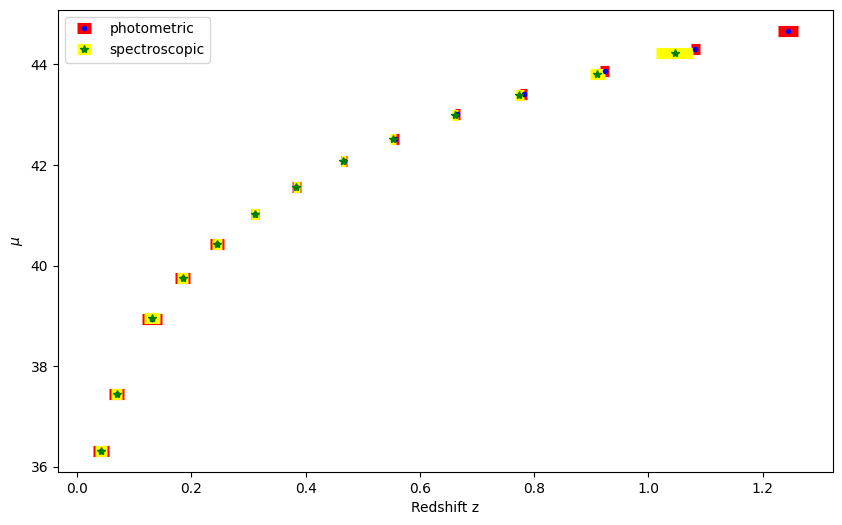

In [7]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(dfp['zCMB'].values, dfp['MU'].values, xerr=dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values, fmt='.', color='b', elinewidth=8, ecolor='red', label='photometric')
plt.errorbar(dfs['zCMB'].values, dfs['MU'].values, xerr=dfs['MUERR_SYS'].values+dfs['MUERR_SYS'].values, fmt='*', color='g', elinewidth=8, ecolor='yellow', label='spectroscopic')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [8]:
dfp['errors'] = dfp['MUERR_SYS'].values+dfp['MUERR_SYS'].values
dfp.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01348
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01254
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.01736
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01316
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01180


In [9]:
dfp = dfp[['zCMB', 'MU', 'errors']]

In [10]:
len(dfp)

14

In [11]:
dfp.head()

,zCMB,MU,errors
0,0.04131,36.31666,0.01348
1,0.06876,37.44798,0.01254
2,0.13121,38.94492,0.01736
3,0.18499,39.75545,0.01316
4,0.24503,40.42469,0.01180


In [12]:
noise1x = 0.005*np.random.rand(len(dfp))
noise1y = np.zeros((14, 2))
noise1y[:,0] = noise1x * 2
noise1y[:,1] = noise1x * 0.1

noise2x = 0.005*np.random.rand(len(dfp))
noise2y = np.zeros((14, 2))
noise2y[:,0] = noise2x * 2
noise2y[:,1] = noise2x * 0.1


In [13]:
np.shape(noise1y)

(14, 2)

In [14]:
z_or = dfp.values[:,0]
y_or = dfp.values[:,1:]

z = np.append(z_or, z_or+noise1x)
z = np.append(z, z_or+noise2x)

y = np.append(y_or, y_or+noise1y, axis=0)
y = np.append(y, y_or+noise2y, axis=0)


randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [15]:
np.shape(y), np.shape(z)

((42, 2), (42,))

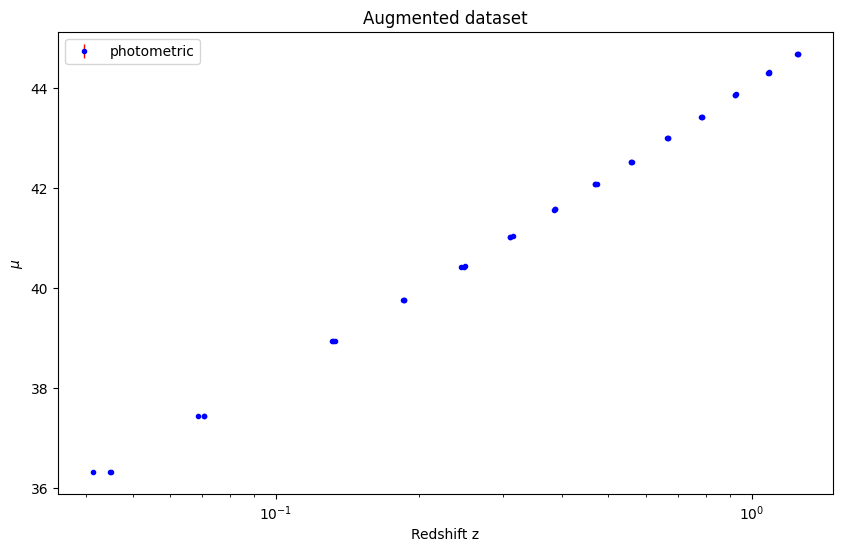

In [16]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red', label='photometric')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.title("Augmented dataset")
plt.xscale('log')
plt.legend()

In [17]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [18]:
split = 0.9
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [19]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [20]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((35,), (37,), (9, 1), (9, 1))

In [21]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 1
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,100,100, 100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_2 (MCDropout)     (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [22]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=5000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/5000
37/37 [==============================] - 1s 4ms/step - loss: 856.1081 - val_loss: 819.9076
Epoch 2/5000
37/37 [==============================] - 0s 2ms/step - loss: 852.1251 - val_loss: 816.0194
Epoch 3/5000
37/37 [==============================] - 0s 2ms/step - loss: 850.8283 - val_loss: 807.4783
Epoch 4/5000
37/37 [==============================] - 0s 2ms/step - loss: 847.5082 - val_loss: 809.3714
Epoch 5/5000
37/37 [==============================] - 0s 2ms/step - loss: 843.7350 - val_loss: 811.6063
Epoch 6/5000
37/37 [==============================] - 0s 2ms/step - loss: 839.1564 - val_loss: 797.2689
Epoch 7/5000
37/37 [==============================] - 0s 2ms/step - loss: 837.5459 - val_loss: 799.3869
Epoch 8/5000
37/37 [==============================] - 0s 2ms/step - loss: 832.0225 - val_loss: 794.2793
Epoch 9/5000
37/37 [==============================] - 0s 2ms/step - loss: 820.9579 - val_loss: 782.2022
Epoch 10/5000
37/37 [==============================] - 0s 2ms/st

Epoch 80/5000
37/37 [==============================] - 0s 2ms/step - loss: 57.8312 - val_loss: 32.8833
Epoch 81/5000
37/37 [==============================] - 0s 2ms/step - loss: 48.6574 - val_loss: 56.9099
Epoch 82/5000
37/37 [==============================] - 0s 2ms/step - loss: 56.8703 - val_loss: 56.3144
Epoch 83/5000
37/37 [==============================] - 0s 2ms/step - loss: 73.7300 - val_loss: 63.9205
Epoch 84/5000
37/37 [==============================] - 0s 2ms/step - loss: 62.6632 - val_loss: 84.5824
Epoch 85/5000
37/37 [==============================] - 0s 2ms/step - loss: 43.8063 - val_loss: 50.2474
Epoch 86/5000
37/37 [==============================] - 0s 2ms/step - loss: 51.7583 - val_loss: 67.5738
Epoch 87/5000
37/37 [==============================] - 0s 2ms/step - loss: 57.1556 - val_loss: 40.1448
Epoch 88/5000
37/37 [==============================] - 0s 2ms/step - loss: 55.3428 - val_loss: 45.9759
Epoch 89/5000
37/37 [==============================] - 0s 2ms/step - loss

Epoch 159/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.6393 - val_loss: 14.6368
Epoch 160/5000
37/37 [==============================] - 0s 2ms/step - loss: 44.7418 - val_loss: 13.5246
Epoch 161/5000
37/37 [==============================] - 0s 2ms/step - loss: 40.9133 - val_loss: 27.1803
Epoch 162/5000
37/37 [==============================] - 0s 2ms/step - loss: 39.1990 - val_loss: 25.5547
Epoch 163/5000
37/37 [==============================] - 0s 2ms/step - loss: 33.7572 - val_loss: 18.9603
Epoch 164/5000
37/37 [==============================] - 0s 2ms/step - loss: 52.6681 - val_loss: 19.6438
Epoch 165/5000
37/37 [==============================] - 0s 2ms/step - loss: 63.0318 - val_loss: 32.4874
Epoch 166/5000
37/37 [==============================] - 0s 2ms/step - loss: 54.2091 - val_loss: 62.5157
Epoch 167/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.5995 - val_loss: 28.6460
Epoch 168/5000
37/37 [==============================] - 0s 2ms/s

Epoch 238/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.3271 - val_loss: 35.5615
Epoch 239/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.6758 - val_loss: 82.5136
Epoch 240/5000
37/37 [==============================] - 0s 2ms/step - loss: 66.2907 - val_loss: 34.0413
Epoch 241/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.5669 - val_loss: 7.7004
Epoch 242/5000
37/37 [==============================] - 0s 2ms/step - loss: 41.8389 - val_loss: 31.3405
Epoch 243/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.6966 - val_loss: 70.4871
Epoch 244/5000
37/37 [==============================] - 0s 2ms/step - loss: 38.9848 - val_loss: 41.8773
Epoch 245/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.4693 - val_loss: 50.0991
Epoch 246/5000
37/37 [==============================] - 0s 2ms/step - loss: 43.8628 - val_loss: 24.6750
Epoch 247/5000
37/37 [==============================] - 0s 2ms/st

Epoch 317/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.0876 - val_loss: 37.9151
Epoch 318/5000
37/37 [==============================] - 0s 2ms/step - loss: 47.1496 - val_loss: 112.5107
Epoch 319/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.2100 - val_loss: 41.2729
Epoch 320/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.2230 - val_loss: 14.4708
Epoch 321/5000
37/37 [==============================] - 0s 2ms/step - loss: 40.7355 - val_loss: 24.5475
Epoch 322/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.5358 - val_loss: 79.8209
Epoch 323/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.0602 - val_loss: 19.0155
Epoch 324/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.9459 - val_loss: 13.5234
Epoch 325/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.2700 - val_loss: 6.1779
Epoch 326/5000
37/37 [==============================] - 0s 2ms/s

Epoch 396/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.1083 - val_loss: 25.1737
Epoch 397/5000
37/37 [==============================] - 0s 2ms/step - loss: 43.6150 - val_loss: 42.5038
Epoch 398/5000
37/37 [==============================] - 0s 2ms/step - loss: 34.4068 - val_loss: 23.0993
Epoch 399/5000
37/37 [==============================] - 0s 2ms/step - loss: 43.9457 - val_loss: 2.4568
Epoch 400/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.4880 - val_loss: 26.3410
Epoch 401/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.3907 - val_loss: 46.4852
Epoch 402/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.0754 - val_loss: 14.1942
Epoch 403/5000
37/37 [==============================] - 0s 2ms/step - loss: 38.5754 - val_loss: 13.4566
Epoch 404/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.8011 - val_loss: 15.9855
Epoch 405/5000
37/37 [==============================] - 0s 2ms/st

Epoch 475/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.6451 - val_loss: 14.9930
Epoch 476/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.4262 - val_loss: 13.1668
Epoch 477/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.6853 - val_loss: 15.4892
Epoch 478/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.8044 - val_loss: 31.4660
Epoch 479/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.0660 - val_loss: 7.5707
Epoch 480/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.9839 - val_loss: 29.4142
Epoch 481/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.8767 - val_loss: 9.7764
Epoch 482/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.9469 - val_loss: 11.2530
Epoch 483/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.3670 - val_loss: 29.7262
Epoch 484/5000
37/37 [==============================] - 0s 2ms/ste

Epoch 554/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.7923 - val_loss: 23.8274
Epoch 555/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.4903 - val_loss: 71.6903
Epoch 556/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.6718 - val_loss: 20.9812
Epoch 557/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.0754 - val_loss: 10.1362
Epoch 558/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.3429 - val_loss: 17.0991
Epoch 559/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.0905 - val_loss: 21.9434
Epoch 560/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.9456 - val_loss: 8.0226
Epoch 561/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.6259 - val_loss: 28.7366
Epoch 562/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.4198 - val_loss: 35.3952
Epoch 563/5000
37/37 [==============================] - 0s 2ms/st

Epoch 633/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.7555 - val_loss: 22.6944
Epoch 634/5000
37/37 [==============================] - 0s 2ms/step - loss: 33.2606 - val_loss: 32.7048
Epoch 635/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.7909 - val_loss: 29.1020
Epoch 636/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.6138 - val_loss: 10.5321
Epoch 637/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.9669 - val_loss: 22.8442
Epoch 638/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.5199 - val_loss: 13.3720
Epoch 639/5000
37/37 [==============================] - 0s 2ms/step - loss: 31.3566 - val_loss: 18.1154
Epoch 640/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.7508 - val_loss: 15.3775
Epoch 641/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.4078 - val_loss: 18.2932
Epoch 642/5000
37/37 [==============================] - 0s 2ms/s

Epoch 712/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.3775 - val_loss: 20.4736
Epoch 713/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.7952 - val_loss: 10.6029
Epoch 714/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.8870 - val_loss: 27.4400
Epoch 715/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.4011 - val_loss: 25.1748
Epoch 716/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.8578 - val_loss: 10.5428
Epoch 717/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.1712 - val_loss: 16.4854
Epoch 718/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.4155 - val_loss: 13.7868
Epoch 719/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.4772 - val_loss: 18.6820
Epoch 720/5000
37/37 [==============================] - 0s 2ms/step - loss: 37.5554 - val_loss: 17.0581
Epoch 721/5000
37/37 [==============================] - 0s 2ms/s

Epoch 791/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.5105 - val_loss: 16.3957
Epoch 792/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.4431 - val_loss: 28.2816
Epoch 793/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.7515 - val_loss: 15.5971
Epoch 794/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.1008 - val_loss: 28.8319
Epoch 795/5000
37/37 [==============================] - 0s 2ms/step - loss: 32.2740 - val_loss: 22.8427
Epoch 796/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.1986 - val_loss: 9.1307
Epoch 797/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.5474 - val_loss: 33.8667
Epoch 798/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.6070 - val_loss: 8.2509
Epoch 799/5000
37/37 [==============================] - 0s 2ms/step - loss: 36.1047 - val_loss: 16.5203
Epoch 800/5000
37/37 [==============================] - 0s 2ms/ste

Epoch 870/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.0180 - val_loss: 28.7590
Epoch 871/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.4786 - val_loss: 47.8074
Epoch 872/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.4728 - val_loss: 12.4323
Epoch 873/5000
37/37 [==============================] - 0s 2ms/step - loss: 14.1959 - val_loss: 25.8343
Epoch 874/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.6950 - val_loss: 14.1836
Epoch 875/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.0713 - val_loss: 33.8628
Epoch 876/5000
37/37 [==============================] - 0s 2ms/step - loss: 34.6179 - val_loss: 18.6887
Epoch 877/5000
37/37 [==============================] - 0s 2ms/step - loss: 38.1893 - val_loss: 37.5689
Epoch 878/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.9849 - val_loss: 67.4154
Epoch 879/5000
37/37 [==============================] - 0s 2ms/s

Epoch 949/5000
37/37 [==============================] - 0s 2ms/step - loss: 35.7394 - val_loss: 29.3956
Epoch 950/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.9928 - val_loss: 24.2605
Epoch 951/5000
37/37 [==============================] - 0s 2ms/step - loss: 33.6739 - val_loss: 25.2165
Epoch 952/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.8151 - val_loss: 3.7389
Epoch 953/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.5484 - val_loss: 44.0338
Epoch 954/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.8905 - val_loss: 25.1235
Epoch 955/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.9557 - val_loss: 35.3943
Epoch 956/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.4754 - val_loss: 40.4014
Epoch 957/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.0340 - val_loss: 20.3438
Epoch 958/5000
37/37 [==============================] - 0s 2ms/st

37/37 [==============================] - 0s 2ms/step - loss: 16.5112 - val_loss: 27.8767
Epoch 1028/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.7112 - val_loss: 24.3944
Epoch 1029/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.6259 - val_loss: 16.7963
Epoch 1030/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.7482 - val_loss: 22.5868
Epoch 1031/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.1795 - val_loss: 27.3559
Epoch 1032/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.4286 - val_loss: 5.1057
Epoch 1033/5000
37/37 [==============================] - 0s 2ms/step - loss: 42.8890 - val_loss: 20.5973
Epoch 1034/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.6003 - val_loss: 35.2512
Epoch 1035/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.8237 - val_loss: 33.9853
Epoch 1036/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 20.7430 - val_loss: 23.5369
Epoch 1106/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.1192 - val_loss: 3.9639
Epoch 1107/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.7210 - val_loss: 23.9137
Epoch 1108/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.2221 - val_loss: 8.2355
Epoch 1109/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.3863 - val_loss: 58.3004
Epoch 1110/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.1852 - val_loss: 8.1707
Epoch 1111/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.1650 - val_loss: 35.7404
Epoch 1112/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.7640 - val_loss: 48.6737
Epoch 1113/5000
37/37 [==============================] - 0s 2ms/step - loss: 11.5800 - val_loss: 35.5126
Epoch 1114/5000
37/37 [==============================] - 0s 2ms/step - los

37/37 [==============================] - 0s 2ms/step - loss: 18.9874 - val_loss: 22.7060
Epoch 1184/5000
37/37 [==============================] - 0s 2ms/step - loss: 28.3370 - val_loss: 31.2754
Epoch 1185/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.5282 - val_loss: 10.0913
Epoch 1186/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.4905 - val_loss: 15.1661
Epoch 1187/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.1302 - val_loss: 45.8849
Epoch 1188/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.2734 - val_loss: 10.4237
Epoch 1189/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.3759 - val_loss: 15.1813
Epoch 1190/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.6130 - val_loss: 26.6312
Epoch 1191/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.6438 - val_loss: 8.6951
Epoch 1192/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 19.6582 - val_loss: 25.1772
Epoch 1262/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.2043 - val_loss: 19.8551
Epoch 1263/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.7267 - val_loss: 7.7854
Epoch 1264/5000
37/37 [==============================] - 0s 2ms/step - loss: 25.9728 - val_loss: 50.6301
Epoch 1265/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.3958 - val_loss: 16.1062
Epoch 1266/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.9774 - val_loss: 25.8515
Epoch 1267/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.4502 - val_loss: 35.4037
Epoch 1268/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.4338 - val_loss: 34.9550
Epoch 1269/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.2514 - val_loss: 22.3636
Epoch 1270/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 17.4459 - val_loss: 54.4175
Epoch 1340/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.1715 - val_loss: 28.0965
Epoch 1341/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.6898 - val_loss: 9.0993
Epoch 1342/5000
37/37 [==============================] - 0s 2ms/step - loss: 29.2418 - val_loss: 12.9890
Epoch 1343/5000
37/37 [==============================] - 0s 2ms/step - loss: 12.9628 - val_loss: 20.8379
Epoch 1344/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.9617 - val_loss: 9.4024
Epoch 1345/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.0921 - val_loss: 18.6467
Epoch 1346/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.6071 - val_loss: 18.7311
Epoch 1347/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.7234 - val_loss: 16.3789
Epoch 1348/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 14.7354 - val_loss: 11.8117
Epoch 1418/5000
37/37 [==============================] - 0s 2ms/step - loss: 24.3960 - val_loss: 24.4956
Epoch 1419/5000
37/37 [==============================] - 0s 2ms/step - loss: 19.7264 - val_loss: 32.5636
Epoch 1420/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.3816 - val_loss: 18.5200
Epoch 1421/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.7414 - val_loss: 18.9401
Epoch 1422/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.9490 - val_loss: 35.8807
Epoch 1423/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.1134 - val_loss: 12.5360
Epoch 1424/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.9625 - val_loss: 34.0611
Epoch 1425/5000
37/37 [==============================] - 0s 2ms/step - loss: 26.8136 - val_loss: 17.8957
Epoch 1426/5000
37/37 [==============================] - 0s 2ms/step - 

37/37 [==============================] - 0s 2ms/step - loss: 16.2811 - val_loss: 12.4435
Epoch 1496/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.2390 - val_loss: 19.5309
Epoch 1497/5000
37/37 [==============================] - 0s 2ms/step - loss: 10.0840 - val_loss: 32.9596
Epoch 1498/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.0150 - val_loss: 17.8287
Epoch 1499/5000
37/37 [==============================] - 0s 2ms/step - loss: 18.2605 - val_loss: 18.7988
Epoch 1500/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.9310 - val_loss: 6.0987
Epoch 1501/5000
37/37 [==============================] - 0s 2ms/step - loss: 30.8463 - val_loss: 15.5123
Epoch 1502/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.6886 - val_loss: 17.0442
Epoch 1503/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.8527 - val_loss: 22.5834
Epoch 1504/5000
37/37 [==============================] - 0s 2ms/step - l

37/37 [==============================] - 0s 2ms/step - loss: 15.1679 - val_loss: 8.8103
Epoch 1574/5000
37/37 [==============================] - 0s 2ms/step - loss: 21.3043 - val_loss: 22.8503
Epoch 1575/5000
37/37 [==============================] - 0s 2ms/step - loss: 15.2880 - val_loss: 12.6917
Epoch 1576/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.5736 - val_loss: 6.7967
Epoch 1577/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.4268 - val_loss: 11.9827
Epoch 1578/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.4439 - val_loss: 32.5146
Epoch 1579/5000
37/37 [==============================] - 0s 2ms/step - loss: 11.1776 - val_loss: 11.9703
Epoch 1580/5000
37/37 [==============================] - 0s 2ms/step - loss: 16.7653 - val_loss: 19.9801
Epoch 1581/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.2426 - val_loss: 15.8357
Epoch 1582/5000
37/37 [==============================] - 0s 2ms/step - lo

37/37 [==============================] - 0s 2ms/step - loss: 27.2419 - val_loss: 17.0692
Epoch 1652/5000
37/37 [==============================] - 0s 2ms/step - loss: 23.5509 - val_loss: 39.5153
Epoch 1653/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.4971 - val_loss: 26.4760
Epoch 1654/5000
37/37 [==============================] - 0s 2ms/step - loss: 27.3591 - val_loss: 9.0844
Epoch 1655/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.3104 - val_loss: 17.7712
Epoch 1656/5000
37/37 [==============================] - 0s 2ms/step - loss: 17.8442 - val_loss: 20.7360
Epoch 1657/5000
37/37 [==============================] - 0s 2ms/step - loss: 20.6475 - val_loss: 6.0403
Epoch 1658/5000
37/37 [==============================] - 0s 2ms/step - loss: 22.1126 - val_loss: 35.6059
Epoch 1659/5000
37/37 [==============================] - 0s 2ms/step - loss: 13.7450 - val_loss: 2.0086


In [23]:
model_train.history['val_loss'][-1]

2.008578300476074

(0.0, 200.0)

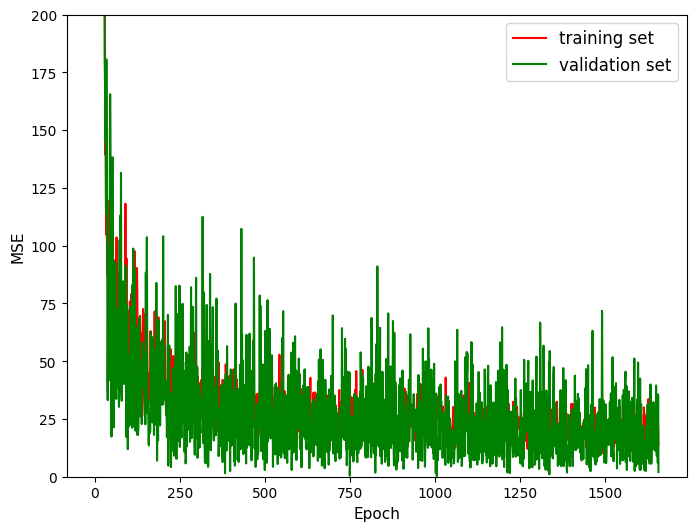

In [24]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [25]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 1.3, test_batch_size)

mc_dropout_num = 200 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 883us/step


16/16 [==============================] - 0s 914us/step


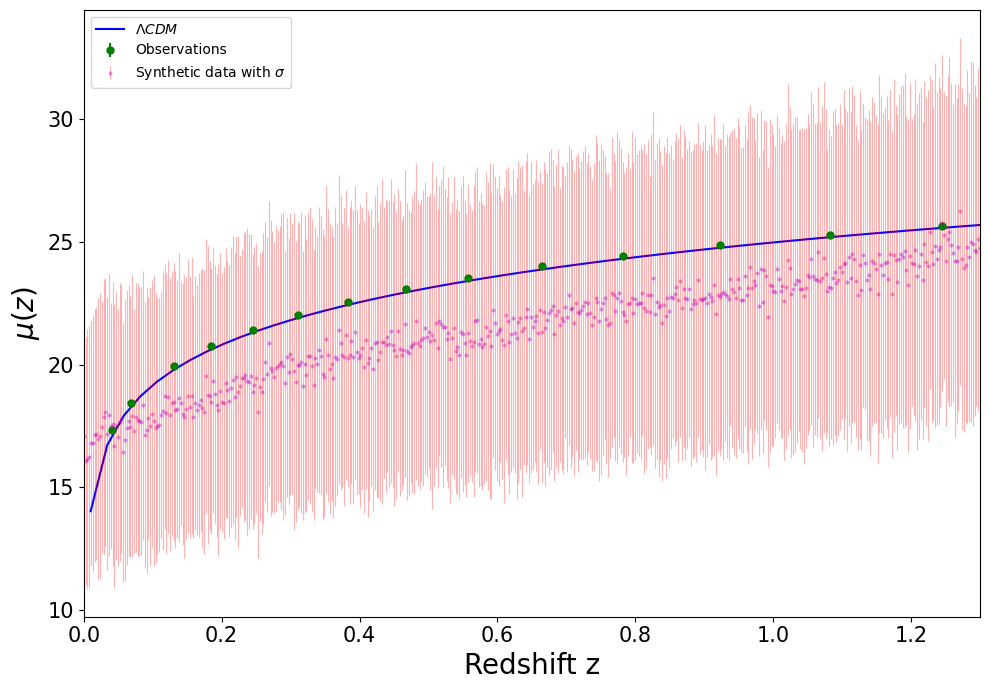

In [26]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(dfp['zCMB'], dfp['MU']-19, dfp['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors